In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
import betting.feature_engineering as features

# Analysis of kaggle odds with metadata

In [3]:
data_path = Path('../data/kaggle/with_meta.feather')
raw_df = pd.read_feather(data_path)
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points
0,194908,league_one,2005-08-06,RC Lens,2,Marseille,0,2.1783,2.9350,3.2050,...,2,0,18,1,0,0,1,0,2,0
1,194909,league_one,2005-08-06,AC Ajaccio,3,Lille,3,2.6657,2.8643,2.6014,...,0,1,5,1,1,0,0,1,0,3
2,194910,league_one,2005-08-06,Bordeaux,1,AS Nancy,0,1.5957,3.2500,5.7443,...,0,3,15,1,0,0,1,0,1,0
3,194911,league_one,2005-08-06,FC Metz,0,Le Mans,0,1.9500,3.0157,3.8014,...,4,0,14,1,0,0,1,1,2,0
4,194912,league_one,2005-08-06,AS Monaco,0,Auxerre,2,1.6083,3.2117,5.4483,...,0,3,10,1,0,1,0,0,0,1


In [4]:
raw_df.shape, raw_df.columns

((12500, 33),
 Index(['match_id', 'league', 'match_date', 'home_team', 'home_score',
        'away_team', 'away_score', 'avg_odds_home_win', 'avg_odds_draw',
        'avg_odds_away_win', 'max_odds_home_win', 'max_odds_draw',
        'max_odds_away_win', 'season', 'matchday', 'home_goals', 'away_goals',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points'],
       dtype='object'))

## Features

### Game results

In [5]:
raw_df['result'] = features.results_from_goals(raw_df, 'home_score', 'away_score')

### Target columns

In [6]:
raw_df = features.add_profit_cols(raw_df, 'max_odds_home_win', 'max_odds_draw', 'max_odds_away_win')
raw_df['y_none'] = 0.
raw_df.head()

,match_id,league,match_date,home_team,home_score,away_team,away_score,avg_odds_home_win,avg_odds_draw,avg_odds_away_win,...,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,result,y_home,y_draw,y_away,y_none
0,194908,league_one,2005-08-06,RC Lens,2,Marseille,0,2.1783,2.9350,3.2050,...,0,1,0,2,0,-1,1.45,-1.0,-1.0,0.0
1,194909,league_one,2005-08-06,AC Ajaccio,3,Lille,3,2.6657,2.8643,2.6014,...,0,0,1,0,3,0,-1.00,2.0,-1.0,0.0
2,194910,league_one,2005-08-06,Bordeaux,1,AS Nancy,0,1.5957,3.2500,5.7443,...,0,1,0,1,0,-1,0.65,-1.0,-1.0,0.0
3,194911,league_one,2005-08-06,FC Metz,0,Le Mans,0,1.9500,3.0157,3.8014,...,0,1,1,2,0,0,-1.00,2.1,-1.0,0.0
4,194912,league_one,2005-08-06,AS Monaco,0,Auxerre,2,1.6083,3.2117,5.4483,...,1,0,0,0,1,1,-1.00,-1.0,5.0,0.0


### Validation

In [7]:
raw_df.season.unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [8]:
raw_df['valid'] = False
raw_df.loc[raw_df.season>=2013,'valid'] = True

### Cats and conts

In [82]:
cats = ['league', 'home_team', 'away_team']
conts = ['season', 'matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

### DataLoaders

In [83]:
to = TabularPandas(raw_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(raw_df))
dls = to.dataloaders(bs=4096)

In [84]:
dls.show_batch()

,league,home_team,away_team,season,matchday,home_rank,home_games_played,home_wins,home_draw,home_lost,home_total_goals_scored,home_total_goals_received,home_points,away_rank,away_games_played,away_wins,away_draw,away_lost,away_total_goals_scored,away_total_goals_received,away_points,y_home,y_draw,y_away,y_none
0,primera_division,Real Madrid,Mallorca,2009.0,17.000000,2.0,16.000000,1.200000e+01,2.000000e+00,2.000000e+00,40.000000,1.300000e+01,38.000000,4.0,16.000000,9.000000e+00,3.000000e+00,4.0,3.000000e+01,18.000000,3.000000e+01,0.33,-1.00,-1.00,0.0
1,premier_league,Wigan,Man City,2009.0,9.000000,13.0,7.999999,3.000000e+00,-1.900826e-07,5.000000e+00,8.000000,1.500000e+01,9.000000,5.0,7.999999,5.000000e+00,1.000000e+00,2.0,1.500000e+01,10.000000,1.600000e+01,-1.00,2.70,-1.00,0.0
2,primera_division,Getafe,S. Sebastian,2011.0,28.000000,14.0,27.000000,8.000000e+00,9.000000e+00,1.000000e+01,28.000000,3.600000e+01,33.000000,11.0,27.000000,9.000000e+00,7.000000e+00,11.0,3.100000e+01,37.000000,3.400000e+01,1.17,-1.00,-1.00,0.0
3,primera_division,Nàstic,Levante,2006.0,14.000000,20.0,13.000000,9.999998e-01,2.000000e+00,1.000000e+01,11.000000,2.800000e+01,5.000001,16.0,13.000000,3.000000e+00,5.000000e+00,5.0,1.100000e+01,18.000000,1.400000e+01,2.40,-1.00,-1.00,0.0
4,bundesliga,Wolfsburg,FC Bayern,2011.0,2.000000,1.0,1.000000,9.999998e-01,-1.900826e-07,1.078842e-07,3.000001,-5.393437e-07,3.000000,12.0,1.000000,-1.232303e-07,-1.192610e-07,1.0,2.464979e-09,0.999999,-8.384479e-07,-1.00,-1.00,1.00,0.0
5,league_one,Marseille,Thonon Évian FC,2011.0,7.000000,20.0,6.000000,-1.271625e-07,3.000000e+00,3.000000e+00,5.999999,1.000000e+01,3.000000,10.0,6.000000,9.999998e-01,4.000000e+00,1.0,5.999999e+00,6.000001,7.000000e+00,0.45,-1.00,-1.00,0.0
6,premier_league,Chelsea,Wolverhampton,2009.0,13.000000,1.0,12.000000,1.000000e+01,-1.900826e-07,2.000000e+00,29.000000,7.999999e+00,30.000000,19.0,12.000000,2.000000e+00,4.000000e+00,6.0,1.200000e+01,22.000000,1.000000e+01,0.21,-1.00,-1.00,0.0
7,bundesliga,K'lautern,Schalke 04,2005.0,18.000000,18.0,17.000000,3.000000e+00,3.000000e+00,1.100000e+01,23.000000,4.400000e+01,12.000000,4.0,17.000000,8.000000e+00,7.000000e+00,2.0,2.000000e+01,12.000000,3.100000e+01,-1.00,-1.00,0.83,0.0
8,premier_league,Liverpool,Everton,2012.0,36.000001,7.0,35.000001,1.400000e+01,1.200000e+01,9.000000e+00,66.999999,4.200000e+01,53.999999,6.0,35.000001,1.500000e+01,1.400000e+01,6.0,5.200000e+01,38.000000,5.900000e+01,-1.00,2.75,-1.00,0.0
9,primera_division,Espanyol,Racing,2006.0,7.000000,16.0,6.000000,9.999998e-01,2.000000e+00,3.000000e+00,2.000000,6.000000e+00,5.000001,15.0,6.000000,9.999998e-01,2.000000e+00,3.0,4.000000e+00,7.999999,4.999999e+00,-1.00,2.27,-1.00,0.0


In [85]:
len(dls.train_ds), len(dls.valid_ds)

(9717, 2783)

# Model

In [86]:
def offset(actuals, targets):
    return 5+features.odds_loss(actuals, targets)

In [87]:
def neg_lr_find(learn, offset=5):
    old_loss = learn.loss_func
    def loss(actuals, targets):
        return offset + old_loss(actuals, targets)
    learn.loss_func = loss
    learn.lr_find()
    learn.loss_func = old_loss

In [130]:
config = tabular_config(ps=.1)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, layers=[10,5], wd=1e-2)#, config=config)
learn.model = learn.model.to('cuda')

{'ps': 0.1}

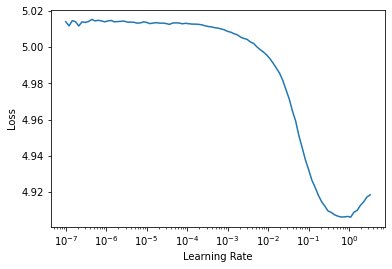

In [170]:
neg_lr_find(learn)

In [171]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,odds_profit,time
0,0.017549,0.009308,-25.905302,00:00
1,0.004389,0.008476,-23.588943,00:00
2,-0.008097,0.006922,-19.263105,00:00
3,-0.027811,0.006701,-18.649622,00:00
4,-0.056475,0.016187,-45.047112,00:00
5,-0.090519,0.016920,-47.088264,00:00
6,-0.124796,0.025191,-70.106552,00:00
7,-0.155586,0.043302,-120.509621,00:00
8,-0.182910,0.053897,-149.995331,00:00
9,-0.205350,0.057228,-159.264801,00:00


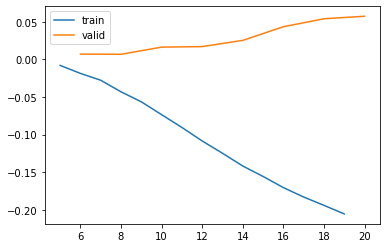

In [172]:
learn.recorder.plot_loss()

## Recent seasons

In [174]:
recent_df = raw_df.loc[raw_df.season>=2008,:].copy()

In [176]:
cats = ['league']
conts = ['season', 'matchday',
        'home_rank', 'home_games_played', 'home_wins', 'home_draw', 'home_lost',
        'home_total_goals_scored', 'home_total_goals_received', 'home_points',
        'away_rank', 'away_games_played', 'away_wins', 'away_draw', 'away_lost',
        'away_total_goals_scored', 'away_total_goals_received', 'away_points']

to = TabularPandas(recent_df, cat_names=cats, procs=[Categorify, Normalize],
                   cont_names = conts,
                   y_names=['y_home', 'y_draw', 'y_away', 'y_none'],
                   splits=ColSplitter('valid')(recent_df))
dls = to.dataloaders(bs=4096)

In [181]:
config = tabular_config(ps=.1)

learn = tabular_learner(dls, loss_func=features.odds_loss, metrics=features.odds_profit, layers=[10,5], wd=1e-2)#, config=config)
learn.model = learn.model.to('cuda')

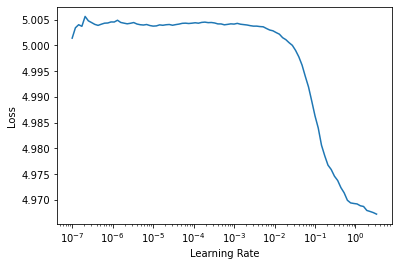

In [182]:
neg_lr_find(learn)

In [183]:
learn.fit_one_cycle(15, 5e-2)

epoch,train_loss,valid_loss,odds_profit,time
0,0.000743,0.000145,-0.402433,00:00
1,0.004361,-0.000172,0.479634,00:00
2,0.003578,-0.000482,1.340505,00:00
3,0.001233,-0.000019,0.054089,00:00
4,0.001820,-0.000582,1.620134,00:00
5,0.000302,-0.001161,3.230304,00:00
6,-0.002164,-0.000768,2.138007,00:00
7,-0.005213,-0.003896,10.841584,00:00
8,-0.009186,-0.006458,17.973894,00:00
9,-0.013188,-0.010477,29.157597,00:00


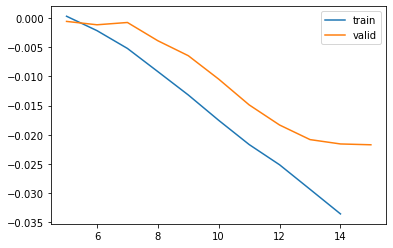

In [184]:
learn.recorder.plot_loss()

# Season evaluation

In [186]:
for season, df in recent_df.groupby('season'):
    print(season)

2008
2009
2010
2011
2012
2013
2014


In [ ]:
to.